In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

# 1. Fonctions

In [3]:
def initialisation(dimensions):
    # ici dimensions représente les couches de notre réseau de neurones
    parametres = {}
    C = len(dimensions)
    
    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)
    
    return parametres

In [4]:
parametres = initialisation([2, 32, 32, 1])

for key, val in parametres.items():
    print(key, val.shape)

W1 (32, 2)
b1 (32, 1)
W2 (32, 32)
b2 (32, 1)
W3 (1, 32)
b3 (1, 1)


In [5]:
def forward_propagation(X, parametres):
    
    activations = {'A0' : X}
    C = len(parametres) // 2 # Car pour 2 couches, nous avons 4 parametres: W1, b1, W2, b2
    
    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))
    
    return activations

In [6]:
activations = forward_propagation(X, parametres)

for key, val in activations.items():
    print(key, val.shape)

A0 (2, 100)
A1 (32, 100)
A2 (32, 100)
A3 (1, 100)


In [7]:
def back_propagation(y, activations, parametres):
    
    m = y.shape[1]
    C = len(parametres) // 2
    
    dZ = activations['A' + str(C)] - y
    gradients = {}
    
    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])
    
    return gradients

In [8]:
gradients = back_propagation(y, activations, parametres)

for key, val in gradients.items():
    print(key, val.shape)

dW3 (1, 32)
db3 (1, 1)
dW2 (32, 32)
db2 (32, 1)
dW1 (32, 2)
db1 (32, 1)


In [9]:
def update(gradients, parametres, learning_rate):
    
    C = len(parametres) // 2
    
    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [10]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [11]:
def log_loss(A, y):
    epsilon = 1e-15
    return 1/len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

In [12]:
def visualisation(X, y, parametres, ax):
    C = len(parametres) // 2
    resolution = 300
    ax[2].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolor='k')

    #limites du graphique
    xlim = ax[2].get_xlim()
    ylim = ax[2].get_ylim()

    # meshgrid
    x1 = np.linspace(xlim[0], xlim[1], resolution)
    x2 = np.linspace(ylim[0], ylim[1], resolution)
    X1, X2 = np.meshgrid(x1, x2)

    # assembler les 2 variables
    XX = np.vstack((X1.ravel(), X2.ravel())).T

    # Prédictions
    for c in range(1, C + 1):
        Z = predict(XX, parametres)
        Z = Z.reshape((resolution, resolution))

        ax[2].pcolormesh(X1, X2, Z, zorder=0, alpha=0.1)
        ax[2].contour(X1, X2, Z, colors='g')

In [16]:
def neural_network(X, y, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 1000):
    
    np.random.seed(0)
    # Initialisation
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    parametres = initialisation(dimensions)
    
    train_loss = []
    train_acc = []
    
    for i in tqdm(range(n_iter)):
        
        activations = forward_propagation(X, parametres)
        gradients   = back_propagation(y, activations, parametres)
        parametres  = update(gradients, parametres, learning_rate)
        
        if i % 10 == 0:
            C = len(parametres) // 2
            train_loss.append(log_loss(y, activations['A' + str(C)]))
            y_pred = predict(X, parametres)
            current_accuracy = accuracy_score(y.flatten(), y_pred.flatten())
            train_acc.append(current_accuracy)
            
    # Visualisation des résultats
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
    ax[0].plot(train_loss, label='Train loss')
    ax[0].legend()
    
    ax[1].plot(train_acc, label='Train acc')
    ax[1].legend()
    # visualisation(X, y, parametres, ax)
    plt.show()
    
    return parametres

# Test sur Dataset

dimensions de X: (2, 100)
dimensions de y: (1, 100)


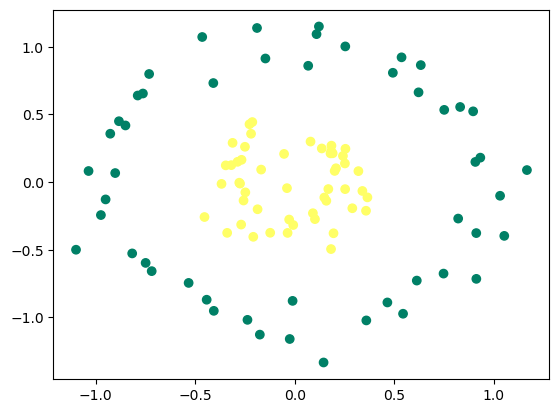

In [14]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2441.58it/s]


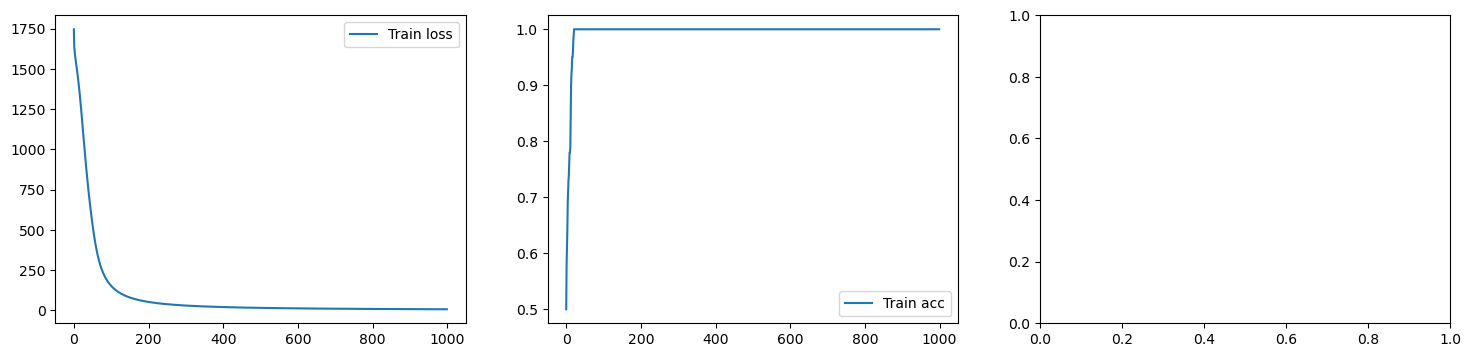

{'W1': array([[ 1.95579927,  0.53100002],
        [ 1.35844769,  1.85462073],
        [ 2.63129029, -1.53981706],
        [ 0.73686918, -0.53907029],
        [-0.41029767,  1.61434077],
        [-0.0947054 ,  1.70890131],
        [ 1.61671547, -0.17796815],
        [-0.86277087,  0.52132914],
        [ 2.70835061, -0.42111255],
        [ 0.61958065, -1.79809735],
        [-2.75194898,  0.45424508],
        [ 1.34870127, -0.9822619 ],
        [ 2.54473959, -1.89258284],
        [ 0.3889497 ,  0.513743  ],
        [ 1.79347793,  1.78121035],
        [ 0.69791268,  1.06455997],
        [-0.94104014, -2.0028442 ],
        [-1.26428963,  0.52311285],
        [ 2.14686892,  1.05721612],
        [-0.75042538, -0.63375388],
        [-1.23300201, -1.87735377],
        [-1.85724572,  2.43816905],
        [ 0.15766383, -0.20793721],
        [-1.45898285,  1.40828484],
        [-0.99004568, -0.30912053],
        [-0.91447782, -0.16617565],
        [-0.20350166, -2.15784462],
        [-0.13932419, 

In [17]:
neural_network(X, y, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 10000)